In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV
from xgboost import XGBRegressor

## 1. Decision Trees as Interpretable Models

### (a) Download the Accute Inflamations data from https://archive.ics.uci.edu/ml/datasets/Acute+Inflammations.

In [2]:
file_path = "../data/diagnosis.data"

column_names = ["Temperature", "Nausea", "Lumbar Pain", "Urine Pushing", 
                "Micturition Pain", "Burning Urethra", "Bladder Inflammation", "Nephritis"]

data = pd.read_csv(file_path, encoding='utf-16', sep='\t', names=column_names, decimal=',')

data.head()

,Temperature,Nausea,Lumbar Pain,Urine Pushing,Micturition Pain,Burning Urethra,Bladder Inflammation,Nephritis
0,35.5,no,yes,no,no,no,no,no
1,35.9,no,no,yes,yes,yes,yes,no
2,35.9,no,yes,no,no,no,no,no
3,36.0,no,no,yes,yes,yes,yes,no
4,36.0,no,yes,no,no,no,no,no


In [3]:
data.replace({'yes': 1, 'no': 0}, inplace=True)

data = data.infer_objects()

class_conditions = [
    (data['Bladder Inflammation'] == 0) & (data['Nephritis'] == 0),
    (data['Bladder Inflammation'] == 1) & (data['Nephritis'] == 0),
    (data['Bladder Inflammation'] == 0) & (data['Nephritis'] == 1),
    (data['Bladder Inflammation'] == 1) & (data['Nephritis'] == 1)
]

class_values = [0, 1, 2, 3]

data['Class'] = np.select(class_conditions, class_values)

data

/var/folders/p8/0vdkghbx2cb6p90k82nbd1lc0000gn/T/ipykernel_94521/3877697314.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace({'yes': 1, 'no': 0}, inplace=True)


,Temperature,Nausea,Lumbar Pain,Urine Pushing,Micturition Pain,Burning Urethra,Bladder Inflammation,Nephritis,Class
0,35.5,0,1,0,0,0,0,0,0
1,35.9,0,0,1,1,1,1,0,1
2,35.9,0,1,0,0,0,0,0,0
3,36.0,0,0,1,1,1,1,0,1
4,36.0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
115,41.4,0,1,1,0,1,0,1,2
116,41.5,0,0,0,0,0,0,0,0
117,41.5,1,1,0,1,0,0,1,2
118,41.5,0,1,1,0,1,0,1,2


### (b) Build a decision tree on the whole data set and plot it.

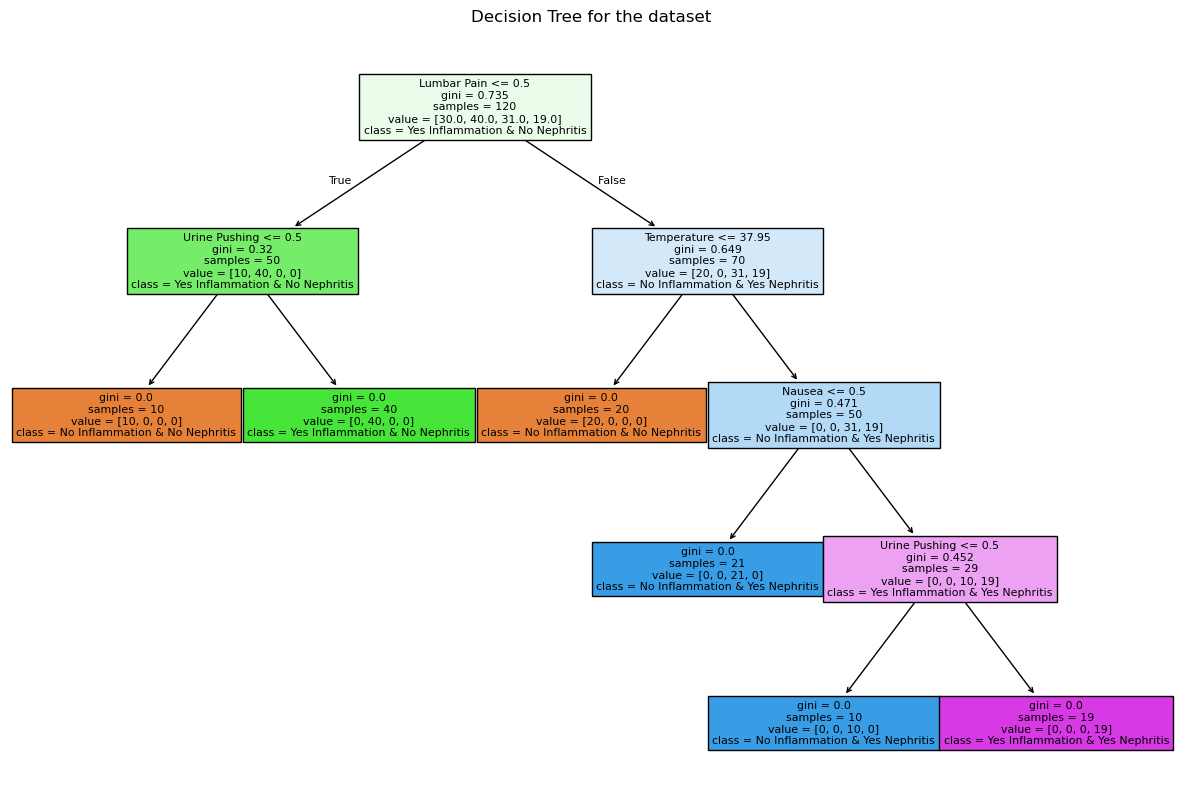

In [4]:
features = data.columns[:-3]  
X = data[features] 
y = data['Class']   

dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X, y)

class_labels = [
    "No Inflammation & No Nephritis",
    "Yes Inflammation & No Nephritis",
    "No Inflammation & Yes Nephritis",
    "Yes Inflammation & Yes Nephritis"
]

plt.figure(figsize=(15, 10))
plot_tree(dt_classifier, feature_names=features, class_names=class_labels, filled=True)
plt.title("Decision Tree for the dataset")
plt.show()

### (c) Convert the decision rules into a set of IF-THEN rules.

In [5]:
def tree_to_if_then(tree, feature_names):
    left = tree.tree_.children_left
    right = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features = [feature_names[i] if i != -2 else "undefined" for i in tree.tree_.feature]
    value = tree.tree_.value

    def recurse(left, right, threshold, features, node, depth=0):
        indent = "  " * depth  
        if threshold[node] != -2:  
            print(f"{indent}IF ( {features[node]} <= {threshold[node]:.6f} ) {{")
            if left[node] != -1:
                recurse(left, right, threshold, features, left[node], depth + 1)
            print(f"{indent}}} ELSE {{")
            if right[node] != -1:
                recurse(left, right, threshold, features, right[node], depth + 1)
            print(f"{indent}}}")
        else:  
            class_values = value[node][0]
            predicted_class = class_values.argmax()
            print(f"{indent}RETURN Class {predicted_class};")

    recurse(left, right, threshold, features, 0)

tree_to_if_then(dt_classifier, features.tolist())


IF ( Lumbar Pain <= 0.500000 ) {
  IF ( Urine Pushing <= 0.500000 ) {
    RETURN Class 0;
  } ELSE {
    RETURN Class 1;
  }
} ELSE {
  IF ( Temperature <= 37.950001 ) {
    RETURN Class 0;
  } ELSE {
    IF ( Nausea <= 0.500000 ) {
      RETURN Class 2;
    } ELSE {
      IF ( Urine Pushing <= 0.500000 ) {
        RETURN Class 2;
      } ELSE {
        RETURN Class 3;
      }
    }
  }
}


### (d) Use cost-complexity pruning to find a minimal decision tree and a set of decision rules with high interpretability.

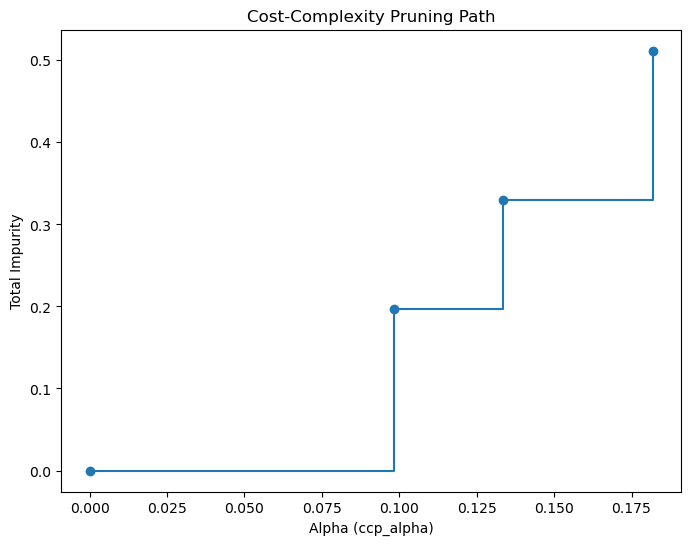

In [6]:
path = dt_classifier.cost_complexity_pruning_path(X, y)
ccp_alphas = path.ccp_alphas[:-1] 
impurities = path.impurities[:-1]

plt.figure(figsize=(8, 6))
plt.plot(ccp_alphas, impurities, marker="o", drawstyle="steps-post")
plt.xlabel("Alpha (ccp_alpha)")
plt.ylabel("Total Impurity")
plt.title("Cost-Complexity Pruning Path")
plt.show()